#Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

#Connect drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read data

In [3]:
data=pd.read_csv("/content/drive/MyDrive/Internspedia/Bombay iron & steel.csv")

# Explore data

In [4]:
data.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
0,10/5/2009,1.00,1.00,1.00,1.00,1.00,50,1,50,50.0,100.0,0.0,0.0
1,2/1/2000,1.05,1.05,1.05,1.05,1.05,150,1,157,NaN,NaN,0.0,0.0
2,12/27/1999,1.00,1.00,1.00,1.00,1.00,200,1,200,NaN,NaN,0.0,0.0
3,9/3/1999,1.40,1.40,1.40,1.40,1.40,100,1,140,NaN,NaN,0.0,0.0
4,8/13/1999,1.45,1.45,1.45,1.45,1.44,50,1,72,NaN,NaN,0.0,0.0


In [5]:
data.tail()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
444,1/14/1991,12.5,15.0,12.5,15.0,0.0,0,0,0,NaN,NaN,2.5,2.5
445,1/11/1991,12.5,12.5,12.0,12.5,0.0,0,0,0,NaN,NaN,0.5,0.0
446,1/9/1991,12.5,15.0,12.5,15.0,0.0,0,0,0,NaN,NaN,2.5,2.5
447,1/7/1991,12.5,15.0,12.5,15.0,0.0,0,0,0,NaN,NaN,2.5,2.5
448,1/3/1991,15.0,15.0,15.0,15.0,0.0,0,0,0,NaN,NaN,0.0,0.0


In [6]:
data.dtypes

Date                          object
Open                         float64
High                         float64
Low                          float64
Close                        float64
WAP                          float64
No. of Shares                  int64
No. of Trades                  int64
Total Turnover                 int64
Deliverable Quantity         float64
% Deli. Qty to Traded Qty    float64
Spread H-L                   float64
Spread C-O                   float64
dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       449 non-null    object 
 1   Open                       449 non-null    float64
 2   High                       449 non-null    float64
 3   Low                        449 non-null    float64
 4   Close                      449 non-null    float64
 5   WAP                        449 non-null    float64
 6   No. of Shares              449 non-null    int64  
 7   No. of Trades              449 non-null    int64  
 8   Total Turnover             449 non-null    int64  
 9   Deliverable Quantity       1 non-null      float64
 10  % Deli. Qty to Traded Qty  1 non-null      float64
 11  Spread H-L                 449 non-null    float64
 12  Spread C-O                 449 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 4

In [8]:
data.columns=['Date', 'Open', 'High', 'Low', 'Close', 'WAP', 'Shares',
       'Trades', 'Total Turnover', 'Deliverable Quantity',
       '% Deli. Qty to Traded Qty', 'Spread H-L', 'Spread C-O']

#Cleaning data

##Drop unnecessary columns


In [9]:
data=data.drop(['WAP', 'Shares',
       'Trades', 'Total Turnover', 'Deliverable Quantity','% Deli. Qty to Traded Qty','Spread H-L', 'Spread C-O'], axis = 1)

In [10]:
data


,Date,Open,High,Low,Close
0,10/5/2009,1.00,1.00,1.00,1.00
1,2/1/2000,1.05,1.05,1.05,1.05
2,12/27/1999,1.00,1.00,1.00,1.00
3,9/3/1999,1.40,1.40,1.40,1.40
4,8/13/1999,1.45,1.45,1.45,1.45
...,...,...,...,...,...
444,1/14/1991,12.50,15.00,12.50,15.00
445,1/11/1991,12.50,12.50,12.00,12.50
446,1/9/1991,12.50,15.00,12.50,15.00
447,1/7/1991,12.50,15.00,12.50,15.00


## Check for duplicates

In [11]:
data.duplicated().sum()

0

#LSTM Model

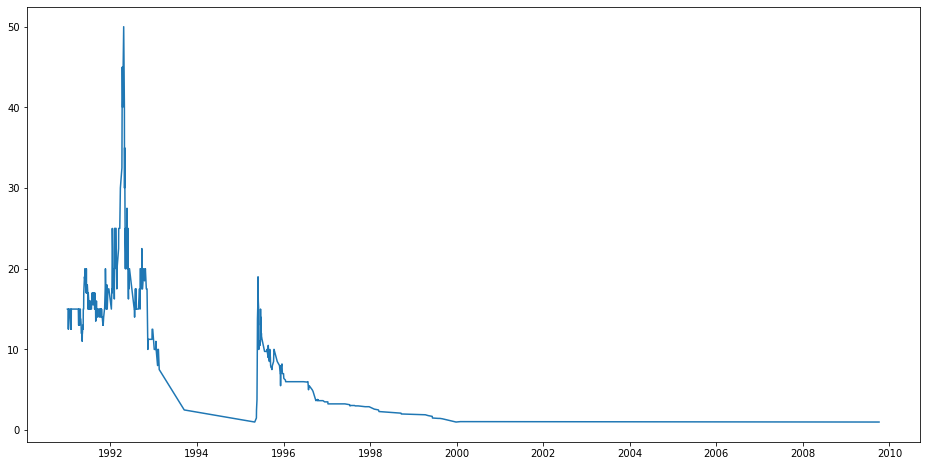

In [12]:
data["Date"]=pd.to_datetime(data.Date,format="%m/%d/%Y")
data.index=data['Date']
plt.figure(figsize=(16,8))
plt.plot(data["Close"],label='Close Price history')

## Sort the dataset on date time and filter “Date” and “Close” columns

In [13]:
data=data.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(data)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

##Normalizing


In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:300,:]
valid_data=final_dataset[300:,:]
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [15]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=10,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=10))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=20,batch_size=1,verbose=2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


240/240 - 9s - loss: 0.0207 - 9s/epoch - 36ms/step
Epoch 2/20
240/240 - 5s - loss: 0.0084 - 5s/epoch - 21ms/step
Epoch 3/20
240/240 - 5s - loss: 0.0075 - 5s/epoch - 22ms/step
Epoch 4/20
240/240 - 5s - loss: 0.0074 - 5s/epoch - 21ms/step
Epoch 5/20
240/240 - 5s - loss: 0.0066 - 5s/epoch - 21ms/step
Epoch 6/20
240/240 - 5s - loss: 0.0064 - 5s/epoch - 21ms/step
Epoch 7/20
240/240 - 7s - loss: 0.0058 - 7s/epoch - 27ms/step
Epoch 8/20
240/240 - 5s - loss: 0.0057 - 5s/epoch - 23ms/step
Epoch 9/20
240/240 - 5s - loss: 0.0058 - 5s/epoch - 20ms/step
Epoch 10/20
240/240 - 5s - loss: 0.0048 - 5s/epoch - 21ms/step
Epoch 11/20
240/240 - 5s - loss: 0.0050 - 5s/epoch - 21ms/step
Epoch 12/20
240/240 - 5s - loss: 0.0047 - 5s/epoch - 20ms/step
Epoch 13/20
240/240 - 5s - loss: 0.0044 - 5s/epoch - 21ms/step
Epoch 14/20
240/240 - 5s - loss: 0.0041 - 5s/epoch - 20ms/step
Epoch 15/20
240/240 - 5s - loss: 0.0039 - 5s/epoch - 22ms/step
Epoch 16/20
240/240 - 5s - loss: 0.0035 - 5s/epoch - 22ms/step
Epoch 17/20


In [16]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


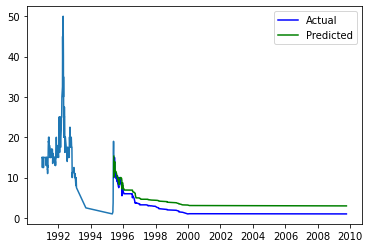

In [20]:
train_data=new_dataset[:300]
valid_data=new_dataset[300:]
valid_data['Predictions']=predicted_closing_price
plt.title='20 Epochs'
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close']],color='blue',label='Actual')
plt.plot(valid_data[["Predictions"]],color='green',label='Predicted')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
print("MeanSquared error: "+ str(mse(valid_data[['Close']], valid_data[["Predictions"]]))) 
print("r2_score: "+str(r2_score(valid_data[['Close']], valid_data[["Predictions"]])*100))

MeanSquared error: 1.9835582287615234
r2_score: 78.94142893806318
